# Kaggle dataset: Pneumonia chest X-Ray

## Introduction

This notebook shows a way to use the Pneumonia chest X-Ray data available on Kaggle to classify X-Ray images using a convolutional neural network. Each image has to be classified in the healthy or pneumonia class. There are two types of pneumonia (due to bacteria or due to virus); we will not try to classify the pneumonia images in these two classes. For more information and to download the dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

To run the code below, don't forget to store the data files in a clearly identified directory and change the paths to these files accordingly in the script.

The CNN training is performed using the Keras (TensorFlow) library.

## Data importation and preprocessing

Let us start by importing and visualizing an image.

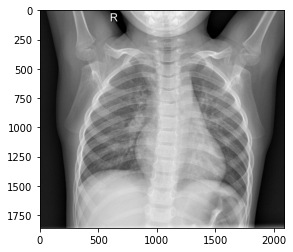

In [1]:
path = "C:/Users/Florian/Documents/PycharmProjects/Pneumonia"

import tensorflow as tf
from matplotlib import pyplot
im1 = tf.image.decode_jpeg(tf.io.read_file(path+"/train/NORMAL/IM-0115-0001.jpeg"))
pyplot.imshow(im1,cmap="gray")

The images are very large ; since my computer is not powerful enough to treat images of this size, they will be resized to 100 x 100 pixels, as follows.

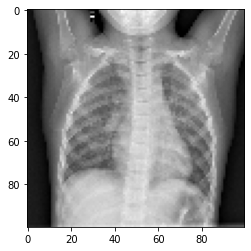

In [2]:
im1 = tf.image.resize(im1,(100,100))
pyplot.imshow(im1,cmap="gray")

Below is introduced the code of the PneumoniaDataset class. The main function of this class, named __build__, performs the following steps :

- list the image files in a given path (function __get_image_files__)
- keep only one file for each patient ; it can be seen that in the pneumonia class, several images can have the same id personXXX where XXX is a number. Keeping all images could lead to a bias in the training process of the CNN (function __unique_persons__)
- import all the selected images, resize them to size im_height x im_width and store them in a numpy array of shape n x im_height x im_width (function __import_images__)
- find the labels corresponding to each image and store them in a numpy array of length n (function __get_labels__).

In [2]:
import os
import numpy as np
class PneumoniaDataset():
    def __init__(self, path, im_height=100, im_width=100):
        self.path = path
        self.im_height = 100
        self.im_width = 100
    def __get_image_files__(self):
        listfiles = []
        for root, dir, files in os.walk(self.path):
            for x in files:
                listfiles.append(os.path.join(root, x))
        listfiles = [x for x in listfiles if "jpeg" in x]
        self.files = np.array(listfiles)
    def __unique_persons__(self):
        def unique_files(files, split):
            files = files[np.core.defchararray.find(files, split) >= 0]
            files_split = np.vstack(np.core.defchararray.split(files, split))[:, 0]
            files_split = np.vstack(np.core.defchararray.split(files_split, "PNEUMONIA\\"))[:, 1]
            id_unique = np.unique(files_split,return_index=True)
            files = files[id_unique[1]]
            return files
        files = self.files
        files_normal = files[np.core.defchararray.find(files,"NORMAL")>=0]
        files_bac = unique_files(files,"bacteria")
        files_virus = unique_files(files,"virus")
        files = [*files_normal, *files_bac, *files_virus]
        self.files = files
    def __import_images__(self):
        files = self.files
        X = np.zeros((len(files), self.im_height, self.im_width), dtype="float32")
        for i in range(len(files)):
            if i % 100 == 0:
                print(str(round(i * 100 / len(files), 2)) + "%")
            im = tf.image.decode_jpeg(tf.io.read_file(files[i]))
            im = tf.image.resize(im, (self.im_height, self.im_width))
            X[i, :, :] = im[:, :, 0]
        X = X / 255.0
        return X
    def __get_labels__(self):
        files = self.files
        labels = np.repeat(1, len(files))
        labels[np.core.defchararray.find(files, "NORMAL") >= 0] = 0
        return np.array(labels)
    def build(self):
        self.__get_image_files__()
        self.__unique_persons__()
        self.X = self.__import_images__()
        self.y = self.__get_labels__()

Uncomment the commented lines below to build the dataset. The final datasets are saved, so that it is not needed to re-build them each time.

In [37]:
import joblib
#path_train = path+"/train"
#data = PneumoniaDataset(path_train)
#data.build()
#joblib.dump(data,path+"/data_train.pkl")
#path_test = path+"/test"
#data = PneumoniaDataset(path_test)
#data.build()
#joblib.dump(data,path+"/data_test.pkl")
data_train = joblib.load(path+"/data_train.pkl")
data_test = joblib.load(path+"/data_test.pkl")

## CNN training

### Data preprocessing for Keras / Tensorflow 

To train the CNN, we must first split the dataset in a training set and a validation set. Note the two last lines below which transform the arrays from shape n x 100 x 100 to n x 100 x 100 x 1. This is due to a constraint in Keras / TensorFlow, which requires the array to be of shape n x height x width x channels, where channels is the number of channels of each image - here channels = 1 since these are grayscale images. For RGB images, channels would be 3.

In [4]:
X = data_train.X
Y = data_train.y
from sklearn.model_selection import train_test_split
Xtrain, Xval, Ytrain, Yval = train_test_split(X,Y,train_size=0.75,random_state=12345)
Xtrain = Xtrain[..., np.newaxis]
Xval = Xval[..., np.newaxis]

### First CNN training

The CNN architecture can now be introduced and trained. Among many possible architectures, this is the one I found to perform best. Note that the elu activation function is used. It indeed performed better than the relu function in my trials. A ModelCheckpoint callback is also used, to save the trained model at a given step if its loss on the validation sample is better than the previously saved model. It is generally a good practice to use this, since it can help avoid overfitting. It is also generally a good practice to use image augmentation, i.e. randomly performing transformations on images of the training set, such as rotation, row or column shift, brightness correction, etc. This is performed by the ImageDataGenerator class used below.

In [7]:
from tensorflow import keras
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(7,7), strides=(2,2), activation="elu", padding="valid",
                        input_shape=[Xtrain.shape[1], Xtrain.shape[2], 1]),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="elu", padding="valid"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="elu", padding="valid"),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation="elu", padding="valid"),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="elu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
])

n_epochs = 50
lr = 0.001
batch_size = 8

aug = keras.preprocessing.image.ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,
                                                   zoom_range=0.2)
aug.fit(Xtrain)
checkpoint = keras.callbacks.ModelCheckpoint(path+"/cnn.h5",monitor="val_loss",save_best_only=True,
                                             mode="min",verbose=1)
model.compile(loss="binary_crossentropy",optimizer=keras.optimizers.Nadam(learning_rate=lr),metrics=["accuracy"])
fitted = model.fit(aug.flow(Xtrain,Ytrain,batch_size=batch_size),epochs=n_epochs,validation_data=(Xval,Yval),
                   callbacks=[checkpoint])

Epoch 1/50
355/355 [==============================] - ETA: 0s - loss: 0.6400 - accuracy: 0.7146
Epoch 00001: val_loss improved from inf to 0.51944, saving model to C:/Users/Florian/Documents/PycharmProjects/Pneumonia\cnn.h5
355/355 [==============================] - 43s 111ms/step - loss: 0.6400 - accuracy: 0.7146 - val_loss: 0.5194 - val_accuracy: 0.7632
Epoch 2/50
355/355 [==============================] - ETA: 0s - loss: 0.4967 - accuracy: 0.7812
Epoch 00002: val_loss did not improve from 0.51944
355/355 [==============================] - 37s 104ms/step - loss: 0.4967 - accuracy: 0.7812 - val_loss: 0.5221 - val_accuracy: 0.7389
Epoch 3/50
355/355 [==============================] - ETA: 0s - loss: 0.4343 - accuracy: 0.8118
Epoch 00003: val_loss improved from 0.51944 to 0.31107, saving model to C:/Users/Florian/Documents/PycharmProjects/Pneumonia\cnn.h5
355/355 [==============================] - 36s 102ms/step - loss: 0.4343 - accuracy: 0.8118 - val_loss: 0.3111 - val_accuracy: 0.8943

Now that the training has finished, the best model saved by the ModelCheckpoint callback can be reloaded to compute the predictions and evaluate the model.

In [9]:
import pandas as pd
model = keras.models.load_model(path+"/cnn.h5")
Xtest = data_test.X
Ytest = data_test.y
prob = model.predict(Xtest)
pred = prob[:,0]>0.5
print("Confusion matrix:\n")
print(pd.crosstab(Ytest,pred))
print("Accuracy: "+str(np.round(np.mean(Ytest==pred),2)))

Confusion matrix:

col_0  False  True
row_0             
0        187    47
1          3   200
Accuracy: 0.89


An accuracy of 89% is obtained, quite close to the 95% obtained on the validation sample when the model was saved (epoch 44). However, the false positive rate is quite high (20%). Let us see if this can be improved.

In [26]:
print("Group sizes in full training sample:")
print(np.bincount(Y))
print("Group sizes in validation sample:")
print(np.bincount(Yval))
print("Group sizes in test sample:")
print(np.bincount(Ytest))

Group sizes in full training sample:
[1341 2443]
Group sizes in validation sample:
[345 601]
Group sizes in test sample:
[234 203]


Whereas the sample size of the "pneumonia" class is almost twice the sample size of the "healthy" class in the training sample (and consequently in the validation sample, since class imbalance was kept unchanged in the train / validation splitting), both classes almost have an equivalent sample size in the test sample. Thus, during training, the "pneumonia" class might take advantage over the "healthy" class. This can be seen in the high false positive rate obtained on the test sample).

### Class imbalance correction

To counteract class imbalance, weights can be used, which will be incorporated in the loss calculations during training, thus giving each class the same importance. The weights must be given in the fit function as a dictionary, mapping each class to the corresponding weight.

In [7]:
from tensorflow import keras
from sklearn.utils.class_weight import compute_sample_weight
w = compute_sample_weight(class_weight="balanced",y=Ytrain)
w0 = w[np.where(Ytrain==0)[0][0]]
w1 = w[np.where(Ytrain==1)[0][0]]
weights = {0: w0, 1: w1}
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(7,7), strides=(2,2), activation="elu", padding="valid",
                        input_shape=[Xtrain.shape[1], Xtrain.shape[2], 1]),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="elu", padding="valid"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="elu", padding="valid"),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation="elu", padding="valid"),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="elu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
])

n_epochs = 50
lr = 0.001
batch_size = 8

aug = keras.preprocessing.image.ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,
                                                   zoom_range=0.2)
aug.fit(Xtrain)
checkpoint = keras.callbacks.ModelCheckpoint(path+"/cnn2.h5",monitor="val_loss",save_best_only=True,
                                             mode="min",verbose=1)
model.compile(loss="binary_crossentropy",optimizer=keras.optimizers.Nadam(learning_rate=lr),metrics=["accuracy"])
fitted = model.fit(aug.flow(Xtrain,Ytrain,batch_size=batch_size),epochs=n_epochs,validation_data=(Xval,Yval),
                   callbacks=[checkpoint],class_weight=weights)

Epoch 1/50
355/355 [==============================] - ETA: 0s - loss: 0.5835 - accuracy: 0.7287
Epoch 00001: val_loss improved from inf to 0.51724, saving model to C:/Users/Florian/Documents/PycharmProjects/Pneumonia\cnn2.h5
355/355 [==============================] - 42s 106ms/step - loss: 0.5835 - accuracy: 0.7287 - val_loss: 0.5172 - val_accuracy: 0.6712
Epoch 2/50
355/355 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.7777
Epoch 00002: val_loss improved from 0.51724 to 0.31092, saving model to C:/Users/Florian/Documents/PycharmProjects/Pneumonia\cnn2.h5
355/355 [==============================] - 41s 114ms/step - loss: 0.4776 - accuracy: 0.7777 - val_loss: 0.3109 - val_accuracy: 0.8689
Epoch 3/50
355/355 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.8048
Epoch 00003: val_loss did not improve from 0.31092
355/355 [==============================] - 38s 107ms/step - loss: 0.4337 - accuracy: 0.8048 - val_loss: 0.9025 - val_accuracy: 0.60

Epoch 28/50
355/355 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.8869
Epoch 00028: val_loss improved from 0.17266 to 0.16382, saving model to C:/Users/Florian/Documents/PycharmProjects/Pneumonia\cnn2.h5
355/355 [==============================] - 35s 98ms/step - loss: 0.2991 - accuracy: 0.8869 - val_loss: 0.1638 - val_accuracy: 0.9387
Epoch 29/50
355/355 [==============================] - ETA: 0s - loss: 0.2761 - accuracy: 0.8904
Epoch 00029: val_loss did not improve from 0.16382
355/355 [==============================] - 34s 96ms/step - loss: 0.2761 - accuracy: 0.8904 - val_loss: 0.5243 - val_accuracy: 0.7706
Epoch 30/50
355/355 [==============================] - ETA: 0s - loss: 0.2994 - accuracy: 0.8802
Epoch 00030: val_loss did not improve from 0.16382
355/355 [==============================] - 34s 96ms/step - loss: 0.2994 - accuracy: 0.8802 - val_loss: 0.1949 - val_accuracy: 0.9281
Epoch 31/50
355/355 [==============================] - ETA: 0s - loss: 0.28

In [10]:
model = keras.models.load_model(path+"/cnn2.h5")
prob = model.predict(Xtest)
pred = prob[:,0]>0.5
print("Confusion matrix:\n")
print(pd.crosstab(Ytest,pred))
print("Accuracy: "+str(np.round(np.mean(Ytest==pred),2)))

Confusion matrix:

col_0  False  True
row_0             
0        205    29
1          4   199
Accuracy: 0.92


The false positive rate has decreased to 12%. It could be decreased even more by tuning the probability threshold, at the cost of a higher false negative rate.